# Predicting Customer Lifetime Value with a Random Forest Classifier

An insurance company wants to construct a model that can give insight into a given policy holder's Customer Lifetime Value for marketing and customer retention purposes. A database of customer features is provided, 7 of which are numerical and the remaining are categorical

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

%matplotlib inline

/AnacondaPython/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Import the data. Preview the dataframe.

In [2]:
df = pd.read_csv("marketing.csv")
df.head(5)

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Now that we have our data, it's time to do some exploratory data analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9134 entries, 0 to 9133
Data columns (total 23 columns):
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               9134 non-null int64
Policy Type                      9

We have no missing values, and a mix of categorical and numeric features. Let's take a look at a basic statistical analysis of the numeric features.

In [4]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


There is a fairly extreme postive skew in the Customer Lifetime Value column, and some mild positive skew in Total Claim Amount.

Because we are going to use dummy variables for our categorical features, it's a good idea to find out how many unique categories are in each categorical feature. 

In [5]:
df_obj = df.select_dtypes(include=['O'])
for col in df_obj:
    print("{}:  ".format(col),df_obj[col].nunique())

State:   5
Response:   2
Coverage:   3
Education:   5
Effective To Date:   59
EmploymentStatus:   5
Gender:   2
Location Code:   3
Marital Status:   3
Policy Type:   3
Policy:   9
Renew Offer Type:   4
Sales Channel:   4
Vehicle Class:   6
Vehicle Size:   3


If a categorical feature has too many unique values, it's predictive power can diminished. Let's take a closer look at the Effective To Date column.

In [6]:
df['Effective To Date'].head()

0    2/24/2011
1    1/31/2011
2    2/19/2011
3    1/20/2011
4     2/3/2011
Name: Effective To Date, dtype: object

In [7]:
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'])
df['Effective To Date'].max() - df['Effective To Date'].min()

Timedelta('58 days 00:00:00')

The Effective To Date only spans 2 months, and will just introduce noise into our model. We will drop the column.

Set target data and feature data.

In [8]:
y = df['Customer Lifetime Value']
X = df.drop(['Customer Lifetime Value','Effective To Date'], 1)

We noticed some skew in our target feature. Let's plot the distribution of the target data.

/AnacondaPython/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


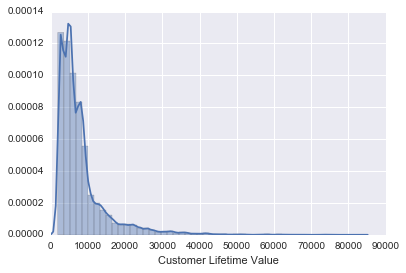

In [9]:
sns.distplot(y)

Our target values are continuous, but predicting categories of CLV might be more informative in the context. We select limits for 5 categories of CLV and bin the target data. Ensure that each bin has a sufficient number of samples.

In [10]:
y = pd.Series(pd.cut(np.array(y),[1000,5000,10000,20000,40000,100000]))
print(y.value_counts())

(5000, 10000]      3782
(1000, 5000]       3466
(10000, 20000]     1311
(20000, 40000]      515
(40000, 100000]      60
dtype: int64


Our target values are ready to fit. Now we need to preprocess our feature data. We scale our numerical features and get dummy variables for our categorical features. Scaling numeric features is not necessary for Random Forests, but it is necessary if we decide to do model comparison with a model that uses a distance metric.

In [11]:
X_num = X.select_dtypes(include=['int64','float64'])
X_cat = X.select_dtypes(include=['O'])

In [12]:
X_num = pd.DataFrame(scale(X_num))
X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_num,X_cat],axis=1)

We fit our Random Forest and use grid search with 5-fold cross validation to find optimal hyperparameters. 

In [13]:
params = {'n_estimators':[10,100,500,2000],'max_depth':[1,3,5,None]}
clf = GridSearchCV(RFC(), params, cv=5, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.0min finished


0.898073133348
{'max_depth': None, 'n_estimators': 2000}


As expected, deeper trees and larger forests produce more accurate results, but the accuracy of the model increases asymptotically with the number of trees in the forest. Let's take a look at a heatmap of parameters vs. accuracy.

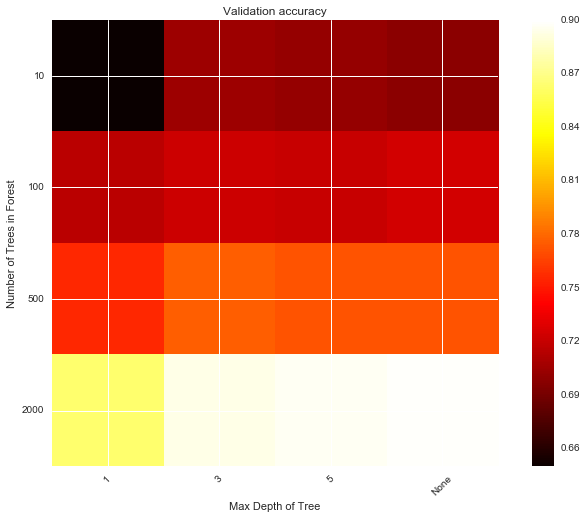

In [14]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(params['n_estimators']), len(params['max_depth']))

plt.figure(figsize=(12, 8))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, vmin=.65, vmax=.90)
plt.xlabel('Max Depth of Tree')
plt.ylabel('Number of Trees in Forest')
plt.colorbar()
plt.xticks(np.arange(len(params['max_depth'])), params['max_depth'], rotation=45)
plt.yticks(np.arange(len(params['n_estimators'])), params['n_estimators'])
plt.title('Validation accuracy')
plt.show()

As a sanity check, let's take a look at the accuracy of a Support Vector Classifier as well.

In [15]:
params = {'C':[10**i for i in range(0,6)], 'gamma':[10**i for i in range(-4,1)]}
clf = GridSearchCV(SVC(), params, cv=5, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  7.8min
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 50.0min finished


0.80370045982
{'C': 100, 'gamma': 0.01}


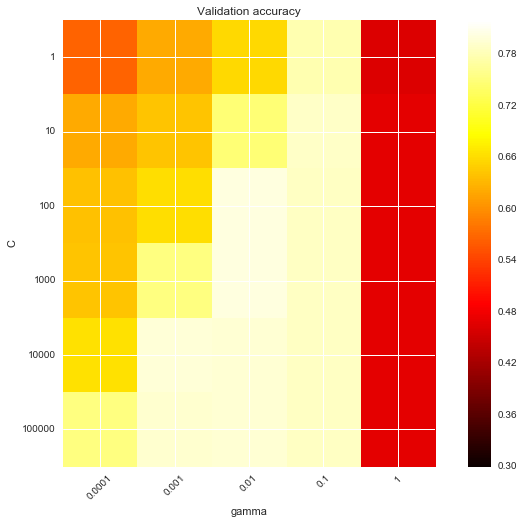

In [16]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(params['C']), len(params['gamma']))

plt.figure(figsize=(12, 8))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, vmin=.3, vmax=.82)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(params['gamma'])), params['gamma'], rotation=45)
plt.yticks(np.arange(len(params['C'])), params['C'])
plt.title('Validation accuracy')
plt.show()

Our Random Forest gets significantly more accurate results. An accurate model of a Customer's Lifetime Value has several crucial uses in the insurance industry, from allocating marketing resources to intelligently reducing churn. 